

## **Emotion-Based Music Recommendations using FER-2013 and Spotify Dataset**


This project uses the FER-2013 dataset to detect emotions from facial expressions using deep learning models such as CNN, VGG16, and ResNet. Based on the detected emotions, the system recommends personalized music tracks from a curated Spotify dataset, matching or enhancing the user's emotional state.

### **Install Kaggle package**

In [ ]:
#!pip install kaggle
# !pip install jupyter-contrib-nbextensions


### **Import necessary libraries**

In [1]:
# Import libraries
import os
import cv2
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **1. FER-2013 Dataset**



The **FER-2013** dataset consists of 48x48 pixel grayscale images of faces, categorized into seven emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, or Neutral. The dataset includes 28,709 images for training and 7,178 for testing.

##### **Data Content**
- Emotion Classes:
 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
- **Total Images**: 35,887
- **Train Images**: 28,709
- **Test Images**: 7,178
- [FER-2013 Dataset](https://www.kaggle.com/datasets/msambare/fer2013)





### **Creating a Directory for Kaggle**

In [2]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Copy kaggle.json to the right location for Kaggle API access
os.makedirs('/root/.kaggle/', exist_ok=True)
!cp /content/drive/MyDrive/Emotion_Detection/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json  # Set permissions

# Step 3: Download and unzip the FER-2013 dataset using the Kaggle API
!kaggle datasets download -d msambare/fer2013 --quiet
!unzip -q fer2013.zip -d /content/fer2013


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0


The kaggle.json file is an essential API access key for Kaggle. It contains two critical pieces of information:

- Username: Your Kaggle username.

- API Key: A secret key that acts like a password, allowing you to access Kaggle's resources programmatically (datasets).

By using the kaggle.json file, you can download datasets and interact with Kaggle directly through code, without needing to manually download files from the website.

In this project, we mount Google Drive in Colab to access the kaggle.json file, which has been previously saved in the Drive.
Once the FER-2013 dataset is downloaded using the Kaggle API, it is unzipped into the current working directory for further use.

### **Project Directory Structure Setup**

In [3]:
# Create the main project directory
main_dir = '/content/project'

# Create subdirectories within the main project directory
sub_dirs = ['eda', 'models', 'outputs']

# Create the main and subdirectories
os.makedirs(main_dir, exist_ok=True)
for sub_dir in sub_dirs:
    os.makedirs(os.path.join(main_dir, sub_dir), exist_ok=True)

#List the directories created
print(f"Directories in '{main_dir}':")
print(os.listdir(main_dir))



Directories in '/content/project':
['models', 'eda', 'outputs']


### **Loading Data from Train and Test Directories**

In [4]:
# Define the directories
train_dir = '/content/fer2013/train'
test_dir = '/content/fer2013/test'

# Function to load images and labels from a given directory
def load_data(directory):
    images = []
    labels = []

    # Loop through each label directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        # Loop through each image in the label directory
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)

            # Load the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Resize the image to 48x48 pixels
            image = cv2.resize(image, (48, 48))

            # Append the image and label to the lists
            images.append(image)
            labels.append(label)

    # Convert lists to numpy arrays for easier manipulation
    return np.array(images), np.array(labels)

# Load the training and testing datasets
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)


### **Pickle to Save the Data**

In [5]:
import os
import pickle

# Create the directory for saving the data
save_dir = '/content/fer2013/data'
os.makedirs(save_dir, exist_ok=True)

# Prepare the dictionary to save data (train and test sets)
data = {
    'train_images': train_images,
    'train_labels': train_labels,
    'test_images': test_images,
    'test_labels': test_labels
}

# Save the preprocessed data locally using pickle
save_path = os.path.join(save_dir, 'data.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(data, f)

# Optionally, save the preprocessed data to Google Drive
drive_save_path = '/content/drive/MyDrive/preprocessed_images.pkl'
with open(drive_save_path, 'wb') as f:
    pickle.dump(data, f)

print("Data saved successfully both locally and to Google Drive!")


Data saved successfully both locally and to Google Drive!


### **Print the contents of dataset directory**

In [6]:
print(os.listdir('/content/'))  # List the contents of the dataset directory

['.config', 'fer2013', 'project', 'drive', 'fer2013.zip', 'sample_data']


### **List Contents of Train and Test Folders**

In [7]:
# Using the dataset variable for the path
print("Contents in Train Folder:", os.listdir(train_dir))
print("Contents in Test Folder:", os.listdir(test_dir))

Contents in Train Folder: ['fear', 'disgust', 'angry', 'surprise', 'neutral', 'happy', 'sad']
Contents in Test Folder: ['fear', 'disgust', 'angry', 'surprise', 'neutral', 'happy', 'sad']


## **Exploratory Data Analysis**

#### **Get the Count of Images in Each Class (for Train and Test)**

In [8]:
# Function to count images in each class in a given directory
def count_images_in_classes(directory):
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return {}

    class_counts = {}
    emotions = os.listdir(directory)
    for emotion in emotions:
        emotion_path = os.path.join(directory, emotion)
        # Count the number of images in each class
        class_counts[emotion] = len(os.listdir(emotion_path))
    return class_counts

# Function to get the count of images in each class for train and test, and return as a DataFrame
def count_images_in_classes_as_dataframe(train_dir, test_dir):
    train_class_counts = count_images_in_classes(train_dir)
    test_class_counts = count_images_in_classes(test_dir)

    # Create a structured DataFrame
    df = pd.DataFrame({
        'Class': train_class_counts.keys(),
        'Train Count': train_class_counts.values(),
        'Test Count': [test_class_counts.get(cls, 0) for cls in train_class_counts.keys()]
    })
    return df


df_class_counts = count_images_in_classes_as_dataframe(train_dir, test_dir)

# Save the DataFrame to a CSV file in the 'eda' folder
os.makedirs('/content/project/eda', exist_ok=True)
df_class_counts.to_csv('/content/project/eda/class_counts.csv', index=False)

# Display the DataFrame in a clean format
print("Class counts for Train and Test datasets:")
print(df_class_counts)


Class counts for Train and Test datasets:
      Class  Train Count  Test Count
0      fear         4097        1024
1   disgust          436         111
2     angry         3995         958
3  surprise         3171         831
4   neutral         4965        1233
5     happy         7215        1774
6       sad         4830        1247


#### **Color and Size of These Images (for Train and Test)**

###### **Define the Function to Check Image Color and Size**

In [9]:
def check_image_color_and_size(directory):
    image_info = []

    # Loop through each label (emotion class)
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        if len(os.listdir(label_path)) == 0:
            print(f"No images found in {label}")
            continue

        # Loop through a few images (check the first 3 images in each class)
        for i, image_file in enumerate(os.listdir(label_path)[:3]):
            image_path = os.path.join(label_path, image_file)

            # Load the image and check if it's grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            height, width = image.shape[:2]
            color_type = 'Grayscale'

            # Add image info to the list
            image_info.append({
                'Class': label,
                'Image Name': image_file,
                'Color Type': color_type,
                'Size': (height, width)
            })
    return pd.DataFrame(image_info)


In [11]:
train_image_info_df = check_image_color_and_size(train_dir)
test_image_info_df = check_image_color_and_size(test_dir)


###### **Display color and size info**

In [12]:
print("Train Image Info (Color Type, Size):")
print(train_image_info_df)

print("\nTest Image Info (Color Type, Size):")
print(test_image_info_df)


Train Image Info (Color Type, Size):
       Class             Image Name Color Type      Size
0       fear  Training_94351832.jpg  Grayscale  (48, 48)
1       fear  Training_54591423.jpg  Grayscale  (48, 48)
2       fear  Training_99068457.jpg  Grayscale  (48, 48)
3    disgust  Training_26971398.jpg  Grayscale  (48, 48)
4    disgust  Training_82298698.jpg  Grayscale  (48, 48)
5    disgust  Training_80671795.jpg  Grayscale  (48, 48)
6      angry  Training_25593834.jpg  Grayscale  (48, 48)
7      angry  Training_63447078.jpg  Grayscale  (48, 48)
8      angry  Training_27567938.jpg  Grayscale  (48, 48)
9   surprise  Training_64177148.jpg  Grayscale  (48, 48)
10  surprise  Training_18351925.jpg  Grayscale  (48, 48)
11  surprise  Training_55509904.jpg  Grayscale  (48, 48)
12   neutral  Training_57327867.jpg  Grayscale  (48, 48)
13   neutral  Training_37534884.jpg  Grayscale  (48, 48)
14   neutral  Training_79061149.jpg  Grayscale  (48, 48)
15     happy  Training_13444081.jpg  Grayscale  (48

In [13]:
# Save the information to CSV for further analysis
os.makedirs('/content/project/eda', exist_ok=True)  # Ensure the directory exists
train_image_info_df.to_csv('/content/project/eda/train_image_info.csv', index=False)
test_image_info_df.to_csv('/content/project/eda/test_image_info.csv', index=False)

print("Train and Test image information saved to CSV files in /content/project/eda/")


Train and Test image information saved to CSV files in /content/project/eda/



Dataset consists of small-sized 48x48 grayscale images.

### **Display Images from Train and Test Folder**

In [14]:
# Function to display and save random images from the dataset using Plotly for display and Matplotlib for saving
def display_and_save_random_images_by_class(dataset_dir, dataset_type="train", save_name="random_images_per_class.png"):
    emotions = os.listdir(dataset_dir)  # List emotion folders
    image_data = {'image': [], 'emotion': []}

    # Pick one random image from each class
    for emotion in emotions:
        emotion_path = os.path.join(dataset_dir, emotion)
        img_name = random.choice(os.listdir(emotion_path))  # Randomly select one image from the folder
        img_path = os.path.join(emotion_path, img_name)
        image_data['image'].append(img_path)
        image_data['emotion'].append(emotion)

    # Convert to DataFrame
    image_df = pd.DataFrame(image_data)

    # Create a 3x3 grid using Plotly for display
    fig = sp.make_subplots(rows=3, cols=3, subplot_titles=[emotion.capitalize() for emotion in image_df['emotion']])

    # Load and add the images to the Plotly subplots
    for i, row in image_df.iterrows():
        img_path = row['image']
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        # Add image to the subplot
        fig.add_trace(go.Image(z=img_array), row=(i // 3) + 1, col=(i % 3) + 1)

    # Update the layout for Plotly display
    fig.update_layout(height=600, width=600, title_text=f"Random Images from {dataset_type.capitalize()} Dataset")

    # Show the interactive Plotly figure
    fig.show()

    # Now saving the images using Matplotlib
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    # Loop through the sampled images and plot them in the grid
    for i, row in image_df.iterrows():
        img_path = row['image']
        img = Image.open(img_path).convert('RGB')
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(row['emotion'].capitalize())
        ax.axis('off')  # Hide axes

    # Remove any empty subplots (if fewer than 9 emotions)
    for j in range(i+1, 9):
        fig.delaxes(axes[j // 3, j % 3])

    # Adjust layout
    plt.tight_layout()

    # Ensure the 'eda' directory exists
    os.makedirs('/content/project/eda', exist_ok=True)

    # Save the figure as a PNG file using Matplotlib
    save_path = f'/content/project/eda/{save_name}'
    plt.savefig(save_path, dpi=300)
    print(f"Figure saved to {save_path}")

    # Close the plot (to avoid displaying it again)
    plt.close()

# Call the function for the train set (one random image per emotion)
display_and_save_random_images_by_class(train_dir, dataset_type="train", save_name="train_random_images_per_class.png")

# Call the function for the test set (one random image per emotion)
display_and_save_random_images_by_class(test_dir, dataset_type="test", save_name="test_random_images_per_class.png")


Figure saved to /content/project/eda/train_random_images_per_class.png


Figure saved to /content/project/eda/test_random_images_per_class.png


### **Emotion Distribution Visualization (Bar Plot)**

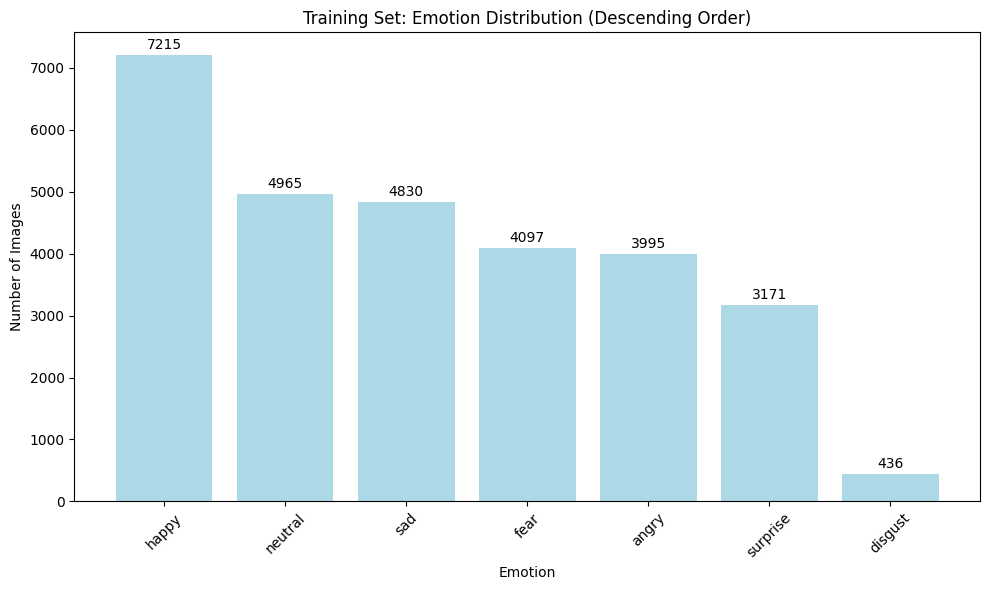

Plot saved to /content/project/eda/train_emotion_distribution_descending.png


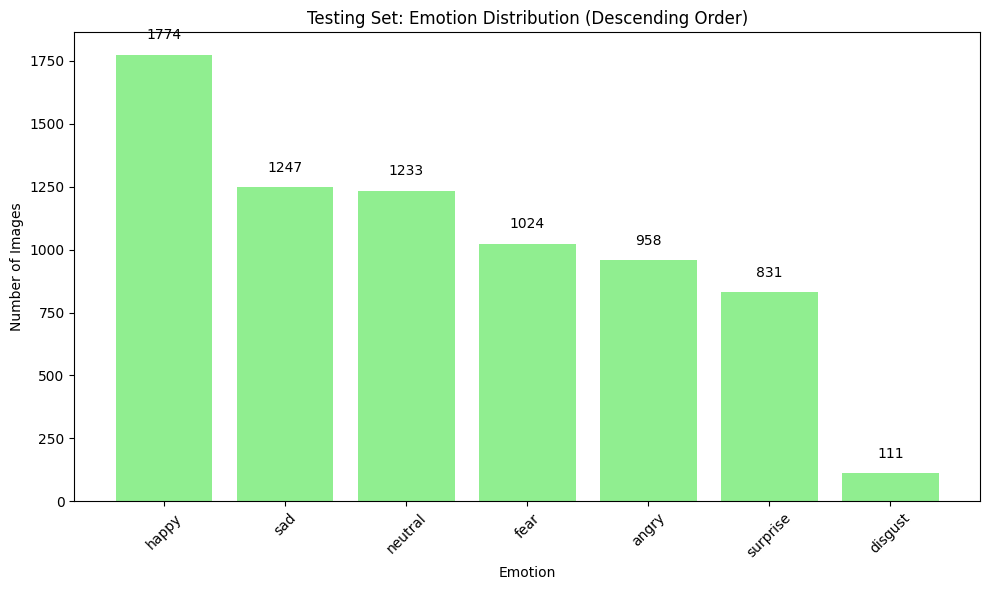

Plot saved to /content/project/eda/test_emotion_distribution_descending.png


In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to count images in each emotion folder
def count_emotion_images(directory):
    emotion_counts = {}
    emotions = os.listdir(directory)
    for emotion in emotions:
        emotion_path = os.path.join(directory, emotion)
        if os.path.isdir(emotion_path):  # Ensure it’s a directory
            emotion_counts[emotion] = len(os.listdir(emotion_path))
    return emotion_counts

# Replace `train_dir` and `test_dir` with your directory paths
train_emotion_counts = count_emotion_images(train_dir)
test_emotion_counts = count_emotion_images(test_dir)

# Convert counts to DataFrames and sort in descending order
train_df_desc = pd.DataFrame(list(train_emotion_counts.items()), columns=['Emotion', 'Count']).sort_values(by='Count', ascending=False)
test_df_desc = pd.DataFrame(list(test_emotion_counts.items()), columns=['Emotion', 'Count']).sort_values(by='Count', ascending=False)

# Create the 'eda' directory if it doesn't exist
os.makedirs('/content/project/eda', exist_ok=True)

# Function to display and save bar plots with count labels and pastel colors
def save_and_display_bar_plot(df, title, save_path, color):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['Emotion'], df['Count'], color=color)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add count labels on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom')

    # Display and save the plot
    plt.show()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Plot saved to {save_path}")

# Display and save the descending order plots
save_and_display_bar_plot(train_df_desc, 'Training Set: Emotion Distribution (Descending Order)', '/content/project/eda/train_emotion_distribution_descending.png', color='lightblue')
save_and_display_bar_plot(test_df_desc, 'Testing Set: Emotion Distribution (Descending Order)', '/content/project/eda/test_emotion_distribution_descending.png', color='lightgreen')


### **Interactive Pie Chart for Emotion Distribution**

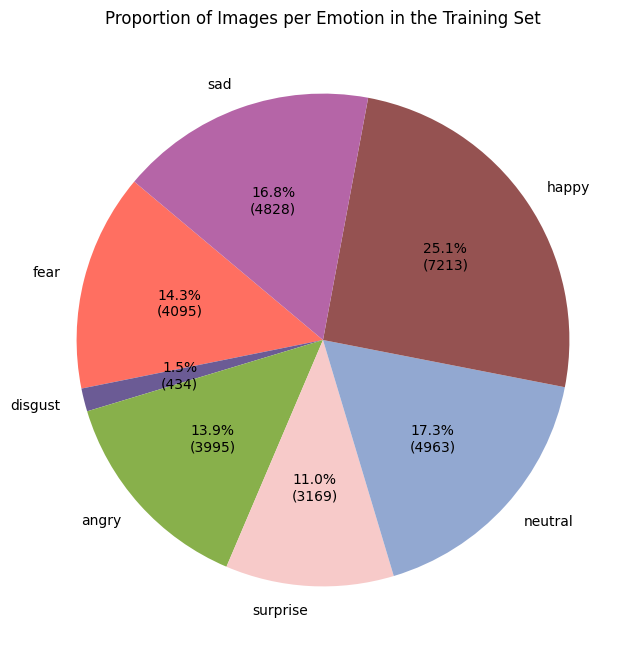

Pie chart saved to /content/project/eda/train_emotion_pie_chart.png


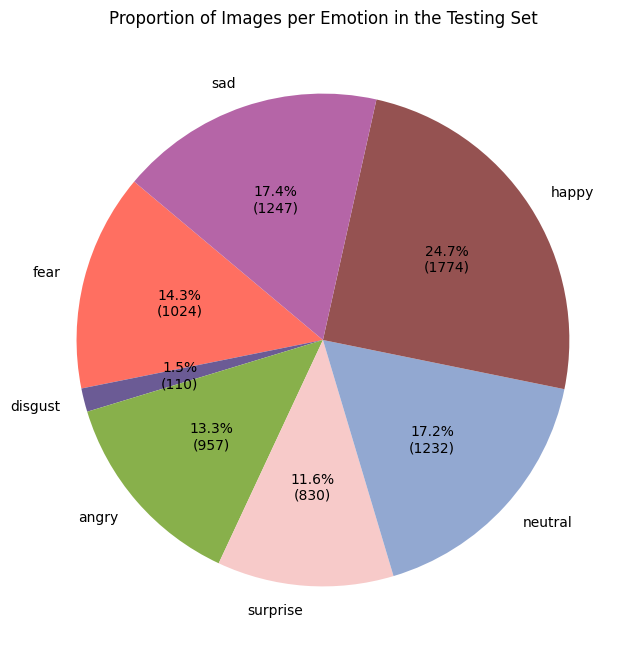

Pie chart saved to /content/project/eda/test_emotion_pie_chart.png


In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Sample data for demonstration purposes
train_emotion_counts = {'fear': 4096, 'disgust': 435, 'angry': 3995, 'surprise': 3170, 'neutral': 4964, 'happy': 7214, 'sad': 4829}
test_emotion_counts = {'fear': 1024, 'disgust': 111, 'angry': 958, 'surprise': 831, 'neutral': 1233, 'happy': 1774, 'sad': 1247}

# Convert counts to DataFrames
train_df = pd.DataFrame(list(train_emotion_counts.items()), columns=['Emotion', 'Count'])
test_df = pd.DataFrame(list(test_emotion_counts.items()), columns=['Emotion', 'Count'])

# Function to plot, display, and save pie charts with colors, counts, and percentages
def plot_and_save_pie_chart(data, title, save_path, colors):
    plt.figure(figsize=(8, 8))

    # Create a pie chart with counts and percentages
    wedges, texts, autotexts = plt.pie(
        data['Count'],
        labels=data['Emotion'],
        autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(data['Count']))})",  # Show percentage and count
        startangle=140,
        colors=colors,
        textprops={'color': "black"}
    )

    # Customize text size and style
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(10)

    # Set the title
    plt.title(title)

    # Display the plot
    plt.show()

    # Ensure the directory exists
    os.makedirs('/content/project/eda', exist_ok=True)

    # Save the pie chart as a PNG file
    plt.savefig(save_path, dpi=300)
    plt.close()  # Close the plot to avoid displaying it again
    print(f"Pie chart saved to {save_path}")

# Define a visually appealing color palette for the pie chart
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', '#955251', '#B565A7']

# Display and save the pie charts for both training and testing sets
plot_and_save_pie_chart(train_df, 'Proportion of Images per Emotion in the Training Set', '/content/project/eda/train_emotion_pie_chart.png', colors)
plot_and_save_pie_chart(test_df, 'Proportion of Images per Emotion in the Testing Set', '/content/project/eda/test_emotion_pie_chart.png', colors)


### **2. Spotify Dataset**

The Spotify dataset contains detailed audio features and metadata for various songs, which are used to match musical moods like Happy, Sad, Energetic, and Calm. This dataset is useful for building mood-based music recommendation systems.

**Data Content:**
- **Total Songs:** 686
- **Columns:** 19
- **Time Period:** Songs span from 1963 to 2020
- [Spotify Music Dataset](https://www.kaggle.com/datasets/musicblogger/spotify-music-data-to-identify-the-moods)


In [28]:
# Download the Spotify dataset from Kaggle
!kaggle datasets download -d musicblogger/spotify-music-data-to-identify-the-moods

# Unzip the dataset
!unzip spotify-music-data-to-identify-the-moods.zip


Dataset URL: https://www.kaggle.com/datasets/musicblogger/spotify-music-data-to-identify-the-moods
License(s): unknown
  0% 0.00/56.0k [00:00<?, ?B/s]
100% 56.0k/56.0k [00:00<00:00, 11.3MB/s]
Archive:  spotify-music-data-to-identify-the-moods.zip
  inflating: data_moods.csv          


### **Load the Dataset**

In [29]:
spotify_df = pd.read_csv('data_moods.csv')

spotify_df.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


### **Proceed with EDA**


#### **Basic information about the dataset**

In [30]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              686 non-null    object 
 1   album             686 non-null    object 
 2   artist            686 non-null    object 
 3   id                686 non-null    object 
 4   release_date      686 non-null    object 
 5   popularity        686 non-null    int64  
 6   length            686 non-null    int64  
 7   danceability      686 non-null    float64
 8   acousticness      686 non-null    float64
 9   energy            686 non-null    float64
 10  instrumentalness  686 non-null    float64
 11  liveness          686 non-null    float64
 12  valence           686 non-null    float64
 13  loudness          686 non-null    float64
 14  speechiness       686 non-null    float64
 15  tempo             686 non-null    float64
 16  key               686 non-null    int64  
 1

#### **Check missing values**

In [31]:
spotify_df.isnull().sum()

,0
name,0
album,0
artist,0
id,0
release_date,0
popularity,0
length,0
danceability,0
acousticness,0
energy,0


#### **Descriptive Statistics**

In [32]:
spotify_df.describe()

,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,41.534985,221791.485423,0.500553,0.449749,0.507693,0.349610,0.166867,0.342438,-11.531020,0.053946,119.134679,5.335277,3.870262
std,23.045707,63399.058492,0.158955,0.410729,0.326490,0.410517,0.142128,0.252304,7.468629,0.041374,28.978685,3.550858,0.500297
min,0.000000,76773.000000,0.078900,0.000005,0.001290,0.000000,0.031800,0.035300,-42.018000,0.023200,50.960000,0.000000,1.000000
25%,30.000000,179114.500000,0.388000,0.014825,0.202000,0.000034,0.092500,0.131250,-15.858750,0.033200,99.008750,2.000000,4.000000
50%,47.000000,213273.000000,0.505000,0.359000,0.495500,0.026350,0.111000,0.282000,-9.358000,0.040700,120.071000,6.000000,4.000000
75%,57.000000,254569.750000,0.612000,0.905750,0.844000,0.858250,0.173750,0.508750,-5.634500,0.057375,132.953250,9.000000,4.000000
max,88.000000,518373.000000,0.941000,0.996000,0.994000,0.966000,0.963000,0.977000,1.342000,0.416000,217.950000,11.000000,5.000000


#### **Mood Distribution**

<ipython-input-33-f9fc62a4b0d0>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




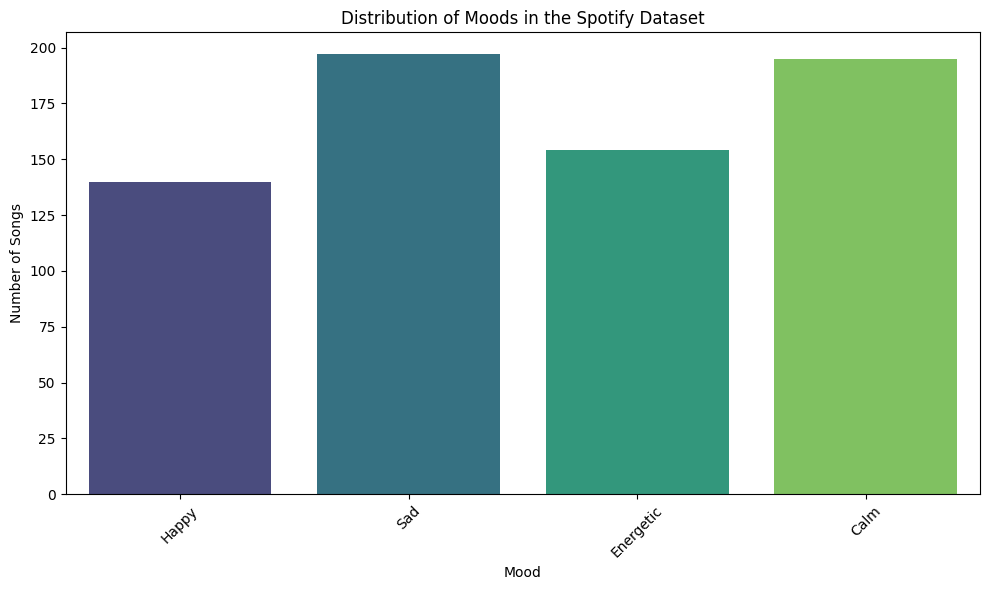

Mood distribution plot saved to /content/project/eda/mood_distribution_spotify.png


In [33]:
# Plot the distribution of moods in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='mood', data=spotify_df, palette='viridis')
plt.title('Distribution of Moods in the Spotify Dataset')
plt.xlabel('Mood')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot to the 'eda' folder before showing it
save_path = '/content/project/eda/mood_distribution_spotify.png'
plt.savefig(save_path, dpi=300)

plt.show()

print(f"Mood distribution plot saved to {save_path}")


#### **Top Songs by Popularity per Mood**

In [34]:
top_songs = spotify_df.groupby('mood').apply(lambda x: x.nlargest(5, 'popularity')).reset_index(drop=True)

# Display top songs for each mood
for mood in top_songs['mood'].unique():
    print(f"\nTop 5 songs in {mood} mood:")
    print(top_songs[top_songs['mood'] == mood][['name', 'artist', 'popularity']])



Top 5 songs in Calm mood:
               name            artist  popularity
0              Lost           Annelie          64
1         Curiosity       Beau Projet          60
2     Escaping Time  Benjamin Martins          60
3  Just Look at You               369          59
4       Mil Sonidos     Reina del Mar          59

Top 5 songs in Energetic mood:
                  name                    artist  popularity
5           Chop Suey!          System Of A Down          79
6  Killing In The Name  Rage Against The Machine          78
7      Dani California     Red Hot Chili Peppers          77
8              Duality                  Slipknot          76
9             Uprising                      Muse          75

Top 5 songs in Happy mood:
                                    name             artist  popularity
10                                Africa               TOTO          84
11                       Pumped Up Kicks  Foster The People          84
12                            T

<ipython-input-34-60b8bc72e8eb>:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<ipython-input-35-ed6955deb0b9>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




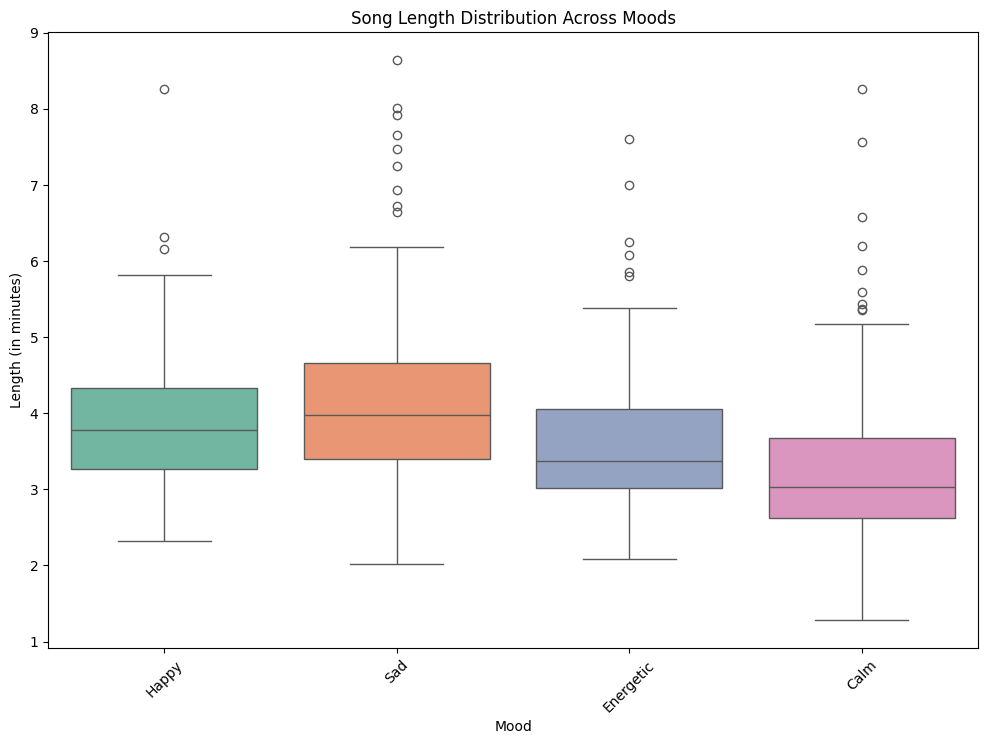

In [35]:
# Convert song length from milliseconds to minutes
spotify_df['length_in_minutes'] = spotify_df['length'] / 60000

# Box plot for song length across moods
plt.figure(figsize=(12, 8))
sns.boxplot(x='mood', y='length_in_minutes', data=spotify_df, palette='Set2')
plt.title('Song Length Distribution Across Moods')
plt.xlabel('Mood')
plt.ylabel('Length (in minutes)')
plt.xticks(rotation=45)
plt.show()


In [36]:
import pickle

# Save the processed data using Pickle
with open('/content/project/eda/spotify_processed_data.pkl', 'wb') as f:
    pickle.dump(spotify_df, f)

print("Processed data saved as Pickle!")


Processed data saved as Pickle!


In [37]:
# Save the processed data as a CSV file
spotify_df.to_csv('/content/project/eda/spotify_processed_data.csv', index=False)

print("Processed data saved as CSV!")


Processed data saved as CSV!


### **Models**

1. [CNN Model](https://colab.research.google.com/drive/1977eMjvylpcGrxSFwpRMru2X0Yx2U1ix?usp=drive_link)
2. [ResNet Model](https://colab.research.google.com/drive/1zCW-SV9fzBFunFv0642QaqIO1eCN9xDL?usp=drive_link)
3. [EfficientNetB0 Model](https://colab.research.google.com/drive/19TqT8ywXUxP5nc5QeZwhCp0bRP4LKtvb?usp=drive_link)
4. [VGG16 Model](https://drive.google.com/file/d/1JVSgPvCBpMqmNBwDVGMzg8FkBNomR5R8/view?usp=drive_link)

In [38]:
# Paths to the saved metrics CSV files in Google Drive
cnn_metrics_csv_path = '/content/drive/MyDrive/Emotion_Detection/CNN_Model/CNN_Output/cnn_model_metrics.csv'
resnet_metrics_csv_path = '/content/drive/MyDrive/Emotion_Detection/ResNet50V2_Model/ResNet50V2_Output/resnet50v2_model_metrics.csv'
efficientnet_metrics_csv_path = '/content/drive/MyDrive/Emotion_Detection/EfficientNETB0_Model/EfficientNET_Output/efficientnet_model_metrics.csv'
vgg16_metrics_csv_path = '/content/drive/MyDrive/Emotion_Detection/VGG16_Model/VGG16_Output/vgg16_model_metrics.csv'

# Load the CSV files into DataFrames
cnn_metrics_df = pd.read_csv(cnn_metrics_csv_path)
resnet_metrics_df = pd.read_csv(resnet_metrics_csv_path)
efficientnet_metrics_df = pd.read_csv(efficientnet_metrics_csv_path)
vgg16_metrics_df = pd.read_csv(vgg16_metrics_csv_path)

# Standardize the metric names for comparison
def standardize_metrics(df, model_name):
    df['Metric'] = df['Metric'].str.replace(f'{model_name} ', '')
    df.rename(columns={'Value': f'{model_name}_Value'}, inplace=True)
    return df

cnn_metrics_df = standardize_metrics(cnn_metrics_df, 'CNN')
resnet_metrics_df = standardize_metrics(resnet_metrics_df, 'ResNet50V2')
efficientnet_metrics_df = standardize_metrics(efficientnet_metrics_df, 'EfficientNetB0')
vgg16_metrics_df = standardize_metrics(vgg16_metrics_df, 'VGG16')

# Merge the DataFrames on the standardized 'Metric' column for comparison
comparison_df = cnn_metrics_df
comparison_df = comparison_df.merge(resnet_metrics_df, on='Metric', how='outer')
comparison_df = comparison_df.merge(efficientnet_metrics_df, on='Metric', how='outer')
comparison_df = comparison_df.merge(vgg16_metrics_df, on='Metric', how='outer')

# Display the comparison DataFrame as a table
display(comparison_df)


,Metric,CNN_Value,ResNet50V2_Value,EfficientNetB0_Value,VGG16_Value
0,Best Epoch,47.00,15.00,21.00,15.00
1,Test Accuracy,0.67,0.68,0.68,0.63
2,Test Loss,0.92,0.92,1.06,1.01
3,Train Accuracy,0.70,0.74,0.76,0.68
4,Train Loss,0.82,0.73,0.78,0.86
5,Validation Accuracy,0.66,0.67,0.67,0.63
6,Validation Loss,0.95,0.94,1.11,1.01
